In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Mar  3 09:25:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd '/content/drive/MyDrive/data/'

/content/drive/MyDrive/data


In [ ]:
!unzip train_no_dup.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 extracting: train/sad/Training_54757164.jpg  
 extracting: train/sad/Training_54772484.jpg  
 extracting: train/sad/Training_5477594.jpg  
 extracting: train/sad/Training_54793062.jpg  
 extracting: train/sad/Training_54802086.jpg  
 extracting: train/sad/Training_54809306.jpg  
 extracting: train/sad/Training_54825179.jpg  
 extracting: train/sad/Training_54856716.jpg  
 extracting: train/sad/Training_54904140.jpg  
 extracting: train/sad/Training_54920035.jpg  
 extracting: train/sad/Training_54947735.jpg  
 extracting: train/sad/Training_54965855.jpg  
 extracting: train/sad/Training_54979023.jpg  
 extracting: train/sad/Training_55064935.jpg  
 extracting: train/sad/Training_55073502.jpg  
 extracting: train/sad/Training_5509151.jpg  
 extracting: train/sad/Training_55098258.jpg  
 extracting: train/sad/Training_55098432.jpg  
 extracting: train/sad/Training_55117900.jpg  
 extracting: train/sad/Training_55124556.jpg  
 extr

In [ ]:
!unzip valid.zip

Archive:  valid.zip
replace valid/angry/PublicTest_10116449.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: valid/angry/PublicTest_10116449.jpg  
 extracting: valid/angry/PublicTest_10813312.jpg  
 extracting: valid/angry/PublicTest_11521746.jpg  
 extracting: valid/angry/PublicTest_11832974.jpg  
 extracting: valid/angry/PublicTest_12296139.jpg  
 extracting: valid/angry/PublicTest_12326319.jpg  
 extracting: valid/angry/PublicTest_12693575.jpg  
 extracting: valid/angry/PublicTest_12700974.jpg  
 extracting: valid/angry/PublicTest_12751829.jpg  
 extracting: valid/angry/PublicTest_12871755.jpg  
 extracting: valid/angry/PublicTest_12919755.jpg  
 extracting: valid/angry/PublicTest_1355981.jpg  
 extracting: valid/angry/PublicTest_13591263.jpg  
 extracting: valid/angry/PublicTest_1373732.jpg  
 extracting: valid/angry/PublicTest_13953782.jpg  
 extracting: valid/angry/PublicTest_14075653.jpg  
 extracting: valid/angry/PublicTest_1419488.jpg  
 extracting: valid/angry/Public

In [ ]:
!unzip test.zip

Archive:  test.zip
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: test/angry/PrivateTest_10131363.jpg  
 extracting: test/angry/PrivateTest_10304478.jpg  
 extracting: test/angry/PrivateTest_1054527.jpg  
 extracting: test/angry/PrivateTest_10590091.jpg  
 extracting: test/angry/PrivateTest_1109992.jpg  
 extracting: test/angry/PrivateTest_11296953.jpg  
 extracting: test/angry/PrivateTest_12000629.jpg  
 extracting: test/angry/PrivateTest_12008383.jpg  
 extracting: test/angry/PrivateTest_12191716.jpg  
 extracting: test/angry/PrivateTest_1221822.jpg  
 extracting: test/angry/PrivateTest_12403575.jpg  
 extracting: test/angry/PrivateTest_12766285.jpg  
 extracting: test/angry/PrivateTest_12846357.jpg  
 extracting: test/angry/PrivateTest_1290484.jpg  
 extracting: test/angry/PrivateTest_12912780.jpg  
 extracting: test/angry/PrivateTest_13164119.jpg  
 extracting: test/angry/PrivateTest_13278552.jpg  
 extracting: test/angry/PrivateTe

In [ ]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 KB 6.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from modelsgd import Net2
from ignite.handlers import *
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
TRAIN_DIR = 'train'
TEST_DIR = 'test'
VAL_DIR = 'valid'
plt.ion()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

42515469


In [ ]:
torch.cuda.empty_cache()

In [ ]:
data_transform = transforms.Compose([
    transforms.Grayscale(),
    #transforms.RandomCrop(size=(48, 48)),
    transforms.RandomAutocontrast(),
    transforms.RandomAdjustSharpness(1.5),
    transforms.AugMix(),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=(0.5,1.5),saturation=(0.5,1.5),hue=(-0.1,0.1)), 
    transforms.ToTensor(),
    #transforms.RandomErasing(scale=(0.02, 0.1), p= 0.5),
    transforms.Normalize((0.4548,), (0.3040,)),
    ]
)
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=data_transform)

test_set = datasets.ImageFolder(root=TEST_DIR, transform=transforms.Compose([
    transforms.Grayscale(),
    #transforms.RandomCrop(size=(48, 48)),
    #transforms.RandomAutocontrast(),
    #transforms.RandomAdjustSharpness(1.5),
    #transforms.AugMix(),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=(0.5,1.5),saturation=(0.5,1.5),hue=(-0.1,0.1)), 
    transforms.ToTensor(),
    #transforms.RandomErasing(scale=(0.02, 0.1), p= 0.5),
    transforms.Normalize((0.4548,), (0.3040,)),
    ]
))
valid_set = datasets.ImageFolder(root=VAL_DIR, transform=transforms.Compose([
    transforms.Grayscale(),
    #transforms.RandomCrop(size=(48, 48)),
    transforms.RandomAutocontrast(),
    transforms.RandomAdjustSharpness(1.5),
    transforms.AugMix(),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=(0.5,1.5),saturation=(0.5,1.5),hue=(-0.1,0.1)), 
    transforms.ToTensor(),
    #transforms.RandomErasing(scale=(0.02, 0.1), p= 0.5),
    transforms.Normalize((0.4548,), (0.3040,))
    ]
))
train_loader = DataLoader(train_dataset, batch_size= 32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)
val_loader = DataLoader(valid_set, batch_size= 32, shuffle=True, num_workers=2)

In [ ]:
model = Net2().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr= 0.0001, weight_decay= 0.0001, momentum= 0.9, nesterov = True)
criterion = nn.CrossEntropyLoss()
#lr_scheduler = StepLR(optimizer, step_size= 10, gamma=0.3)
#lr_scheduler = ExponentialLR(optimizer, gamma=0.9330329915)
#scheduler = LRScheduler(lr_scheduler)
trainer = create_supervised_trainer(model, optimizer, criterion, device)
val_metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
def test(loader, tta=5, str='Validation'):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0

        lst_labels = []
        temp = []
        for i in range(tta):    
            temp.append([])
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                temp[i].append(output)
                if i == 0:
                    lst_labels.append(target)
            
        for i in range(len(temp[0])):           
            zero = torch.zeros_like(temp[0][i])
            for k in range(tta):
                zero += temp[k][i]
            zero = zero / tta
            target = lst_labels[i]
            test_loss += criterion(zero, target).item() * len(zero)
            _, pred = zero.max(1, keepdim=True)
            correct += (pred == target.view_as(pred)).sum().item()


        test_loss /= len(loader.dataset)
        print('\n{} result: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'
              .format(str,test_loss, correct, len(loader.dataset),
                      100. * correct / len(loader.dataset)))
    return test_loss

#train_evaluator = Engine(validation_step)


val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
#test_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
log_interval = 200

#trainer.add_event_handler(Events.EPOCH_COMPLETED, scheduler)
train_loss = []
val_loss = []


In [ ]:
torch.cuda.empty_cache()
lr_finder = FastaiLRFinder()
to_save = {'model': model, 'optimizer': optimizer}
with lr_finder.attach(trainer, to_save, step_mode= 'exp', end_lr=1.0) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_loader)

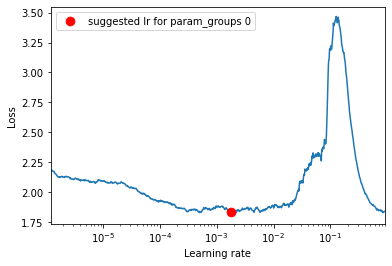

Suggested LR 0.001810222500608411


In [ ]:
lr_finder.plot()
print("Suggested LR", lr_finder.lr_suggestion())

In [ ]:

lr_finder.apply_suggested_lr(optimizer)
print(optimizer.param_groups[0]['lr'])
lr_scheduler = ExponentialLR(optimizer, gamma=0.9330329915)
scheduler = LRScheduler(lr_scheduler)
trainer.add_event_handler(Events.EPOCH_COMPLETED, scheduler)

0.001810222500608411


In [ ]:
@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_result(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")
    train_loss.append(metrics['loss'])

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_result(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f} Lr: {optimizer.param_groups[0]['lr']}")
    val_loss.append(metrics['loss'])

In [ ]:
trainer.run(train_loader, max_epochs=20)        

Epoch[1], Iter[200] Loss: 1.80
Epoch[1], Iter[400] Loss: 1.91
Epoch[1], Iter[600] Loss: 1.84
Epoch[1], Iter[800] Loss: 1.77
Training Results - Epoch[1] Avg accuracy: 0.27 Avg loss: 1.76
Validation Results - Epoch[1] Avg accuracy: 0.25 Avg loss: 1.77 Lr: 0.001810222500608411
Epoch[2], Iter[1000] Loss: 1.82
Epoch[2], Iter[1200] Loss: 1.82
Epoch[2], Iter[1400] Loss: 1.83
Epoch[2], Iter[1600] Loss: 1.81
Training Results - Epoch[2] Avg accuracy: 0.38 Avg loss: 1.59
Validation Results - Epoch[2] Avg accuracy: 0.40 Avg loss: 1.55 Lr: 0.0016889973150232764
Epoch[3], Iter[1800] Loss: 1.72
Epoch[3], Iter[2000] Loss: 1.68
Epoch[3], Iter[2200] Loss: 1.29
Epoch[3], Iter[2400] Loss: 1.25
Epoch[3], Iter[2600] Loss: 1.44
Training Results - Epoch[3] Avg accuracy: 0.46 Avg loss: 1.41
Validation Results - Epoch[3] Avg accuracy: 0.46 Avg loss: 1.38 Lr: 0.0015758902174716355
Epoch[4], Iter[2800] Loss: 1.45
Epoch[4], Iter[3000] Loss: 1.53
Epoch[4], Iter[3200] Loss: 1.30
Epoch[4], Iter[3400] Loss: 1.07
Train

State:
	iteration: 17460
	epoch: 20
	epoch_length: 873
	max_epochs: 20
	output: 0.9918110370635986
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

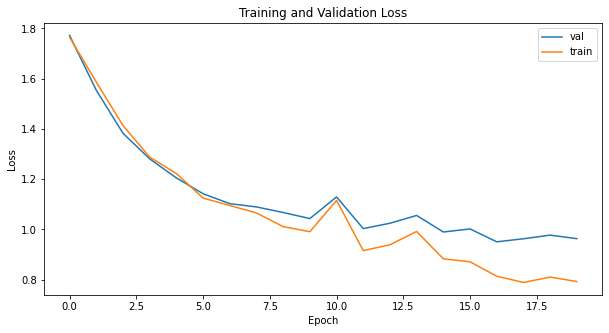

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_loss,label="val")
plt.plot(train_loss,label="train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
val_evaluator.run(test_loader)
metrics = val_evaluator.state.metrics
print(f"Test Results - Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

Test Results - Avg accuracy: 0.66 Avg loss: 0.92


In [ ]:
checkpoint = {
    'epoch': 20 + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    #'scheduler': lr_scheduler.state_dict()
}
torch.save(checkpoint, 'checkpointsgd20ep.pt')

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr= 0.00001, weight_decay= 0.0001, momentum= 0.9, nesterov = True)
#lr_scheduler = ExponentialLR(optimizer, gamma=0.8865681506)
#scheduler = LRScheduler(lr_scheduler)
#trainer.add_event_handler(Events.EPOCH_COMPLETED, scheduler)

In [ ]:
trainer.run(train_loader, max_epochs=30)        #Ong co the chinh len > 50

Epoch[21], Iter[17600] Loss: 0.80
Epoch[21], Iter[17800] Loss: 0.71
Epoch[21], Iter[18000] Loss: 0.61
Epoch[21], Iter[18200] Loss: 0.68
Training Results - Epoch[21] Avg accuracy: 0.72 Avg loss: 0.75
Validation Results - Epoch[21] Avg accuracy: 0.65 Avg loss: 0.97 Lr: 0.00045255562479504333
Epoch[22], Iter[18400] Loss: 0.58
Epoch[22], Iter[18600] Loss: 0.62
Epoch[22], Iter[18800] Loss: 1.19
Epoch[22], Iter[19000] Loss: 0.64
Epoch[22], Iter[19200] Loss: 0.86
Training Results - Epoch[22] Avg accuracy: 0.74 Avg loss: 0.72
Validation Results - Epoch[22] Avg accuracy: 0.65 Avg loss: 0.96 Lr: 0.0004222493284226708
Epoch[23], Iter[19400] Loss: 0.73
Epoch[23], Iter[19600] Loss: 0.78
Epoch[23], Iter[19800] Loss: 0.73
Epoch[23], Iter[20000] Loss: 0.66
Training Results - Epoch[23] Avg accuracy: 0.74 Avg loss: 0.70
Validation Results - Epoch[23] Avg accuracy: 0.66 Avg loss: 0.96 Lr: 0.0003939725540570705
Epoch[24], Iter[20200] Loss: 0.74
Epoch[24], Iter[20400] Loss: 0.93
Epoch[24], Iter[20600] Loss

State:
	iteration: 26190
	epoch: 30
	epoch_length: 873
	max_epochs: 30
	output: 0.3610297441482544
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
val_evaluator.run(test_loader)
metrics = val_evaluator.state.metrics
print(f"Test Results - Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

Test Results - Avg accuracy: 0.68 Avg loss: 0.93


In [ ]:
checkpoint = {
    'epoch': 30 + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': lr_scheduler.state_dict()
}
torch.save(checkpoint, 'checkpointsgd30ep.pt')

In [ ]:
lr_scheduler = ExponentialLR(optimizer, gamma=0.9330329915)
scheduler = LRScheduler(lr_scheduler)
def load_ckp(checkpoint_fpath, model, optimizer, scheduler):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    return model, optimizer, checkpoint['epoch'], scheduler

model, optimizer, start_epoch, lr_scheduler = load_ckp('checkpointsgd30ep.pt', model, optimizer, lr_scheduler) 
trainer.add_event_handler(Events.EPOCH_COMPLETED, scheduler)


In [ ]:
print(optimizer.param_groups[0]['lr'])

0.00024251855440232494


In [ ]:
trainer.run(train_loader, max_epochs=10)        #Ong co the chinh len > 50

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch[1], Iter[200] Loss: 0.83
Epoch[1], Iter[400] Loss: 0.51
Epoch[1], Iter[600] Loss: 0.47
Epoch[1], Iter[800] Loss: 0.52
Training Results - Epoch[1] Avg accuracy: 0.83 Avg loss: 0.48
Validation Results - Epoch[1] Avg accuracy: 0.67 Avg loss: 1.00 Lr: 0.00024251855440232494
Epoch[2], Iter[1000] Loss: 0.57
Epoch[2], Iter[1200] Loss: 0.36
Epoch[2], Iter[1400] Loss: 0.43
Epoch[2], Iter[1600] Loss: 0.39
Training Results - Epoch[2] Avg accuracy: 0.83 Avg loss: 0.48
Validation Results - Epoch[2] Avg accuracy: 0.68 Avg loss: 1.01 Lr: 0.00022627781230825673
Epoch[3], Iter[1800] Loss: 0.42
Epoch[3], Iter[2000] Loss: 0.57
Epoch[3], Iter[2200] Loss: 0.63
Epoch[3], Iter[2400] Loss: 0.51
Epoch[3], Iter[2600] Loss: 0.65
Training Results - Epoch[3] Avg accuracy: 0.84 Avg loss: 0.46
Validation Results - Epoch[3] Avg accuracy: 0.67 Avg loss: 1.02 Lr: 0.0002111246641280483
Epoch[4], Iter[2800] Loss: 0.48
Epoch[4], Iter[3000] Loss: 0.34
Epoch[4], Iter[3200] Loss: 0.44
Epoch[4], Iter[3400] Loss: 0.39
Tr

State:
	iteration: 8730
	epoch: 10
	epoch_length: 873
	max_epochs: 10
	output: 0.27656206488609314
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
val_evaluator.run(test_loader)
metrics = val_evaluator.state.metrics
print(f"Test Results - Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

Test Results - Avg accuracy: 0.69 Avg loss: 1.04


In [ ]:
checkpoint = {
    'epoch': 40 + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': lr_scheduler.state_dict()
}
torch.save(checkpoint, 'checkpointsgd40.pt')

In [ ]:
trainer.run(train_loader, max_epochs=10)        #Ong co the chinh len > 50

Epoch[1], Iter[200] Loss: 0.23
Epoch[1], Iter[400] Loss: 0.46
Epoch[1], Iter[600] Loss: 0.34
Epoch[1], Iter[800] Loss: 0.26
Training Results - Epoch[1] Avg accuracy: 0.90 Avg loss: 0.29
Validation Results - Epoch[1] Avg accuracy: 0.67 Avg loss: 1.12 Lr: 0.0001212592771533266
Epoch[2], Iter[1000] Loss: 0.38
Epoch[2], Iter[1200] Loss: 0.34
Epoch[2], Iter[1400] Loss: 0.25
Epoch[2], Iter[1600] Loss: 0.26
Training Results - Epoch[2] Avg accuracy: 0.90 Avg loss: 0.30
Validation Results - Epoch[2] Avg accuracy: 0.67 Avg loss: 1.13 Lr: 0.00011313890610949592
Epoch[3], Iter[1800] Loss: 0.29
Epoch[3], Iter[2000] Loss: 0.33
Epoch[3], Iter[2200] Loss: 0.33
Epoch[3], Iter[2400] Loss: 0.42
Epoch[3], Iter[2600] Loss: 0.32
Training Results - Epoch[3] Avg accuracy: 0.92 Avg loss: 0.25
Validation Results - Epoch[3] Avg accuracy: 0.67 Avg loss: 1.15 Lr: 0.00010556233202238061
Epoch[4], Iter[2800] Loss: 0.26
Epoch[4], Iter[3000] Loss: 0.36
Epoch[4], Iter[3200] Loss: 0.27
Epoch[4], Iter[3400] Loss: 0.40
Tr

State:
	iteration: 8730
	epoch: 10
	epoch_length: 873
	max_epochs: 10
	output: 0.3706754744052887
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
val_evaluator.run(test_loader)
metrics = val_evaluator.state.metrics
print(f"Test Results - Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

Test Results - Avg accuracy: 0.69 Avg loss: 1.13


In [ ]:
checkpoint = {
    'epoch': 50 + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': lr_scheduler.state_dict()
}
torch.save(checkpoint, 'checkpointsgd50.pt')

In [ ]:
lr_scheduler = ExponentialLR(optimizer, gamma=0.9330329915)
scheduler = LRScheduler(lr_scheduler)
trainer.add_event_handler(Events.EPOCH_COMPLETED, scheduler)
def load_ckp(checkpoint_fpath, model, optimizer, lr_scheduler):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['scheduler'])
    return model, optimizer, checkpoint['epoch'], lr_scheduler

model, optimizer, start_epoch, lr_scheduler = load_ckp('checkpointsgd50.pt', model, optimizer, lr_scheduler) 
scheduler = LRScheduler(lr_scheduler)

In [ ]:
val_evaluator.run(test_loader)
metrics = val_evaluator.state.metrics
print(f"Test Results - Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Test Results - Avg accuracy: 0.67 Avg loss: 1.15


In [ ]:
test(test_loader, str='Test', tta=10)


Test result: Average loss: 0.9867, Accuracy: 2520/3589 (70.2145%)



0.9867020071997686

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


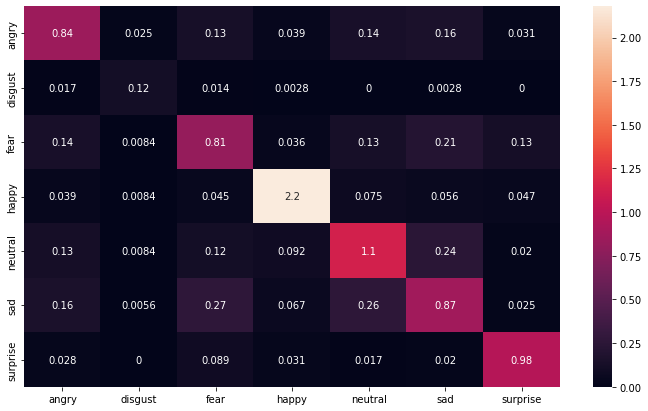

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')